# Popularity Analysis

In [1]:
from google.cloud import bigquery
import pandas_gbq
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'snappy-boulder-378707'
pandas_gbq.context.dialect = 'standard'

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import math
pd.set_option('display.max_columns', 500)

## Preprocessing and feature extraction
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
import datetime as dt
from sklearn.preprocessing import FunctionTransformer

## Models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
import timeit

## Model selection and fine tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import statsmodels.api as sm


# for model export
import joblib

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../BigQuery/letsgo-snappy-boulder-378707-4b7d46801fd1.json"

# Construct a BigQuery client object.
client = bigquery.Client()

In [2]:
%%bigquery track_genre
SELECT * FROM snappy-boulder-378707.TrackGenre.Trackgenre

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
track_genre

,track_id,Alternative,Blues,Cantopop,Classical,Dance Electronic,Folk & Acoustic,Hip-Hop,Indie,Instrumental,Jazz,K-Pop,Latin,Malay Pop,Mandopop,Metal,Musik Indonesia,Pop,R&B,Rock
0,001CyR8xqmmpVZFiTZJ5BC,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,001eyxfoYptAWzvF4ewLrR,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,002LxxV7VTy5JkvkmmGanl,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,002YdWxaenIUL4PHiv5EB5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,002nFT2kRsfvS0d17AwWsB,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74920,7zo6QXVQfHlycm8dsxkRGv,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74921,7zswEelYoepv2FYsDaGhUD,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74922,7zuKKxwcxaeGPrhKoNWdMP,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74923,7zyfphPnDBks6j6uIjttMR,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# Import data

## Audio features

In [4]:
%%bigquery audio_feature
SELECT * FROM snappy-boulder-378707.AudioFeatures.AudioFeatures

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
audio_feature.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'duration_ms', 'time_signature'],
      dtype='object')

In [6]:
audio_feature

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.556,0.7290,0,-5.907,0,0.0432,0.0331,0.015200,0.0907,0.1520,90.003,2LRqm962By8aNwJX0WxFNG,245204,4
1,0.825,0.1240,0,-11.175,0,0.0706,0.8000,0.000003,0.2430,0.2860,104.724,7rXQXbK4pQo8DSKlZ9ZSjC,230333,3
2,0.315,0.1020,0,-17.621,0,0.0340,0.9850,0.051200,0.1090,0.1850,169.690,0Oqxt6JixieLHbwMfnJGWO,206723,3
3,0.440,0.4970,1,-6.440,0,0.0402,0.0917,0.000000,0.2150,0.2090,73.541,6bBNc3V3PduYNL22lbed5R,156892,4
4,0.400,0.4710,1,-12.394,0,0.1610,0.8880,0.048000,0.1150,0.0385,84.481,5ZSqX1dDJ823Dndw94nogY,67804,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75026,0.881,0.0902,10,-13.818,1,0.1410,0.5470,0.897000,0.1360,0.3840,82.010,2hBSZIMfpkSayib4FO684h,117073,4
75027,0.881,0.6960,11,-3.838,0,0.0797,0.1370,0.000041,0.0927,0.7810,97.002,3mQ6SLdxxaL52Yte7KF2Ks,200667,4
75028,0.881,0.5230,11,-4.870,0,0.3380,0.1420,0.000000,0.0771,0.7500,96.506,6xrjmQMIIYgLgjCOeq2dee,211133,4
75029,0.881,0.3610,11,-14.728,0,0.2370,0.0502,0.004580,0.2460,0.7990,96.430,4HfxDJ0uLHTLe0fZrx0MbQ,216693,4


## Tracks info

In [7]:
%%bigquery track_info
SELECT * FROM snappy-boulder-378707.TrackClearInfo.TrackClearInfo
WHERE popularity <> 0 and available_markets <> 0

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
track_info.head()

,id,name,album_id,artist_id,popularity,explicit,available_markets,extract_date
0,4feAlo2wgcAtOx6ED9jw2q,Face in the Crowd,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,36,0,134,2023-04-07
1,6f6jhTzxwvAYhzZrABTO8T,Weekends,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,34,1,134,2023-04-07
2,4xo2cd0kmp3GO1jZzAst1D,Can I Jump?,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,56,0,134,2023-04-07
3,6gVIrj4H3rmXYZnFXxtEl3,midnight rendezvous,4XAi7fxJkMgdqS73Wjte5J,4wkxDp8esk6g2W9Fw7IQGY,45,0,176,2023-04-07
4,2Wd0jIZnZI0gkze7ux0ZXs,Cut (Bendik HK Remix),3RtfM1haEzNzgmANkQPcLJ,0Q6X1jqwOVQuclYp2P1bub,4,0,179,2023-04-07


## Album info

In [9]:
%%bigquery release_date
SELECT id,release_date FROM snappy-boulder-378707.TrackClearInfo.AlbumInfo

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
release_date

,id,release_date
0,7rG4h8pLLcr6kW30cbSWD8,2023-04-07
1,2oRM1rJALdQfceK3i7SxG3,2023-03-24
2,4XAi7fxJkMgdqS73Wjte5J,2023-03-24
3,3RtfM1haEzNzgmANkQPcLJ,2023-03-31
4,22MkBC5l2Zi9atm66fE0Jq,2023-03-22
...,...,...
58130,4nvvfshb8jFXz5dmRL2zEe,2023-03-17
58131,0Z0dI0YMz5SgfXbElTztrs,2023-03-17
58132,65SUE4gUrSXcU2n02NldKN,2023-03-17
58133,2O1vg5NUciYqMXukzwvpIY,2023-03-17


## Artist_info

In [36]:
%%bigquery artist_info
SELECT distinct id, followers, popularity FROM `snappy-boulder-378707.TrackClearInfo.ArtistInfo`

Query is running:   0%|          |

Downloading:   0%|          |

In [12]:
artist_info

,id,followers,popularity
0,7oy3avikyzVHespBjOfjGQ,1.0,0.0
1,5Knvxyf7V57HhloqIWAGas,2.0,0.0
2,6bZ2pW1vt2NJ1XfP3Jwb29,48.0,0.0
3,5zuVGovDZ2VKZVuOiM7hCq,5.0,0.0
4,2eNMeOUJ4rZQ5uO6ie9hy0,48.0,0.0
...,...,...,...
28515,6VuMaDnrHyPL1p4EHjYLi7,19871695.0,83.0
28516,2o5jDhtHVPhrJdv3cEQ99Z,6818785.0,86.0
28517,7CajNmpbOovFoOoasH2HaY,23293100.0,87.0
28518,4MCBfE4596Uoi2O4DtmEMz,28507873.0,90.0


## Merge data

In [104]:
df = pd.merge(audio_feature, track_info, on="id", how="inner")
del df['extract_date']
df.drop_duplicates(inplace=True)

In [105]:
df = pd.merge(release_date, df, left_on="id", right_on="album_id",how="inner")
df.head()
df.drop_duplicates(inplace=True)

In [106]:
df= df.assign(artist_id=df.artist_id.str.split(";")).explode('artist_id')
df = pd.merge(df,artist_info, left_on="artist_id", right_on="id",how="inner")
df.head()
df.drop_duplicates(inplace=True)

In [107]:
df = df.groupby(['id_y','release_date', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'name',
       'popularity_x', 'explicit', 'available_markets'], as_index=False).aggregate({'followers':'mean','popularity_y':'mean'})

In [108]:
del df['id_y']

In [109]:
df.columns

Index(['release_date', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'name',
       'popularity_x', 'explicit', 'available_markets', 'followers',
       'popularity_y'],
      dtype='object')

In [110]:
df.columns = ['release_date', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'name', 'popularity_track', 'explicit',
       'available_markets','followers', 'popularity_artist']

In [111]:
df.drop_duplicates(inplace=True)

In [112]:
df

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,name,popularity_track,explicit,available_markets,followers,popularity_artist
0,2019-07-13,0.238,0.0132,2,-32.252,0,0.0375,0.9940,0.907000,0.0947,0.0410,67.773,224250,4,Desvelarse,35,0,184,325.0,50.0
1,2019-05-08,0.675,0.8290,6,-2.962,0,0.0455,0.1170,0.000844,0.2650,0.6940,108.914,212138,4,Venus 샛별,33,0,183,16378.0,27.0
2,2017-05-05,0.826,0.6790,1,-6.802,1,0.1290,0.3070,0.000025,0.1510,0.8410,90.048,160107,4,She Knows How To Rock Me,30,0,184,271037.0,54.5
3,1976-01-01,0.326,0.1810,0,-17.757,1,0.0473,0.9820,0.032700,0.1980,0.1440,135.032,602267,3,"Die Meistersinger von Nürnberg, WWV 96 / Act I...",22,0,184,159467.8,48.6
4,2022-03-18,0.385,0.1080,0,-21.476,1,0.0537,0.9690,0.107000,0.1080,0.0799,82.763,212827,3,This Foolish Heart Could Love You,42,0,183,322204.5,51.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62832,2018-11-02,0.551,0.8810,7,-6.099,0,0.0542,0.1860,0.079100,0.1520,0.3870,88.036,153000,4,You Get Me So High,80,0,184,12007614.0,85.0
62833,2010-01-01,0.542,0.6560,2,-4.471,0,0.0288,0.0236,0.000000,0.3030,0.2620,117.263,369040,4,Kau Dipaksa Aku Terpaksa,43,0,29,503.0,30.0
62834,2023-01-27,0.651,0.7200,9,-6.529,1,0.1610,0.3310,0.413000,0.5280,0.7050,90.024,269245,4,running out of time,67,0,183,8870042.0,80.0
62835,2014-12-19,0.423,0.3600,3,-9.458,1,0.0372,0.7280,0.000000,0.1050,0.2910,130.576,260573,4,以後別做朋友,60,0,184,1224310.0,67.0


# Data Transformation & Preprocessing

In [113]:
numeric_columns = ['danceability', 'energy', 'loudness', 
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 
       'popularity_track',  'available_markets','followers','popularity_artist']
catego_columns = ['mode','explicit','key', 'time_signature']

In [114]:
imputer_numeric = SimpleImputer(strategy='mean', missing_values=np.nan)
df[numeric_columns] = imputer_numeric.fit_transform(df[numeric_columns])
imputer_catego = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)
df[['mode','explicit','key']] = imputer_catego.fit_transform(df[['mode','explicit','key']])
imputer_catego = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=4)
df[['time_signature']] = imputer_catego.fit_transform(df[['time_signature']])

In [115]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity_track,explicit,available_markets,followers,popularity_artist
count,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,6.283700e+04,62837.000000,62837.000000,62837.000000,62837.000000,6.283700e+04,62837.000000
mean,0.558198,0.524412,5.238570,-10.193798,0.646434,0.072923,0.434445,0.234545,0.170148,0.429467,118.262838,2.292971e+05,3.886023,40.680825,0.085984,175.805035,2.182322e+06,51.094986
std,0.181739,0.279645,3.543646,6.833567,0.478080,0.077004,0.363059,0.367875,0.135772,0.253652,30.631754,9.569073e+04,0.435211,16.632551,0.280343,33.520675,7.160764e+06,18.981878
min,0.000000,0.000097,0.000000,-47.070000,0.000000,0.000000,0.000000,0.000000,0.007240,0.000000,0.000000,1.594900e+04,0.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000
25%,0.440000,0.305000,2.000000,-12.523000,0.000000,0.034700,0.065700,0.000000,0.096700,0.217000,94.005000,1.790770e+05,4.000000,29.000000,0.000000,183.000000,1.015400e+04,39.000000
50%,0.574000,0.545000,5.000000,-8.042000,1.000000,0.044400,0.372000,0.000303,0.116000,0.400000,118.144000,2.156670e+05,4.000000,40.000000,0.000000,184.000000,1.478730e+05,52.000000
75%,0.694000,0.759000,8.000000,-5.544000,1.000000,0.071900,0.802000,0.531000,0.191000,0.628000,137.966000,2.589200e+05,4.000000,52.000000,0.000000,185.000000,1.091512e+06,64.333333
max,0.984000,1.000000,11.000000,0.878000,1.000000,0.960000,0.996000,0.997000,1.000000,0.984000,237.488000,4.170227e+06,5.000000,100.000000,1.000000,185.000000,1.107113e+08,100.000000


## EDA

### Distribution of variables

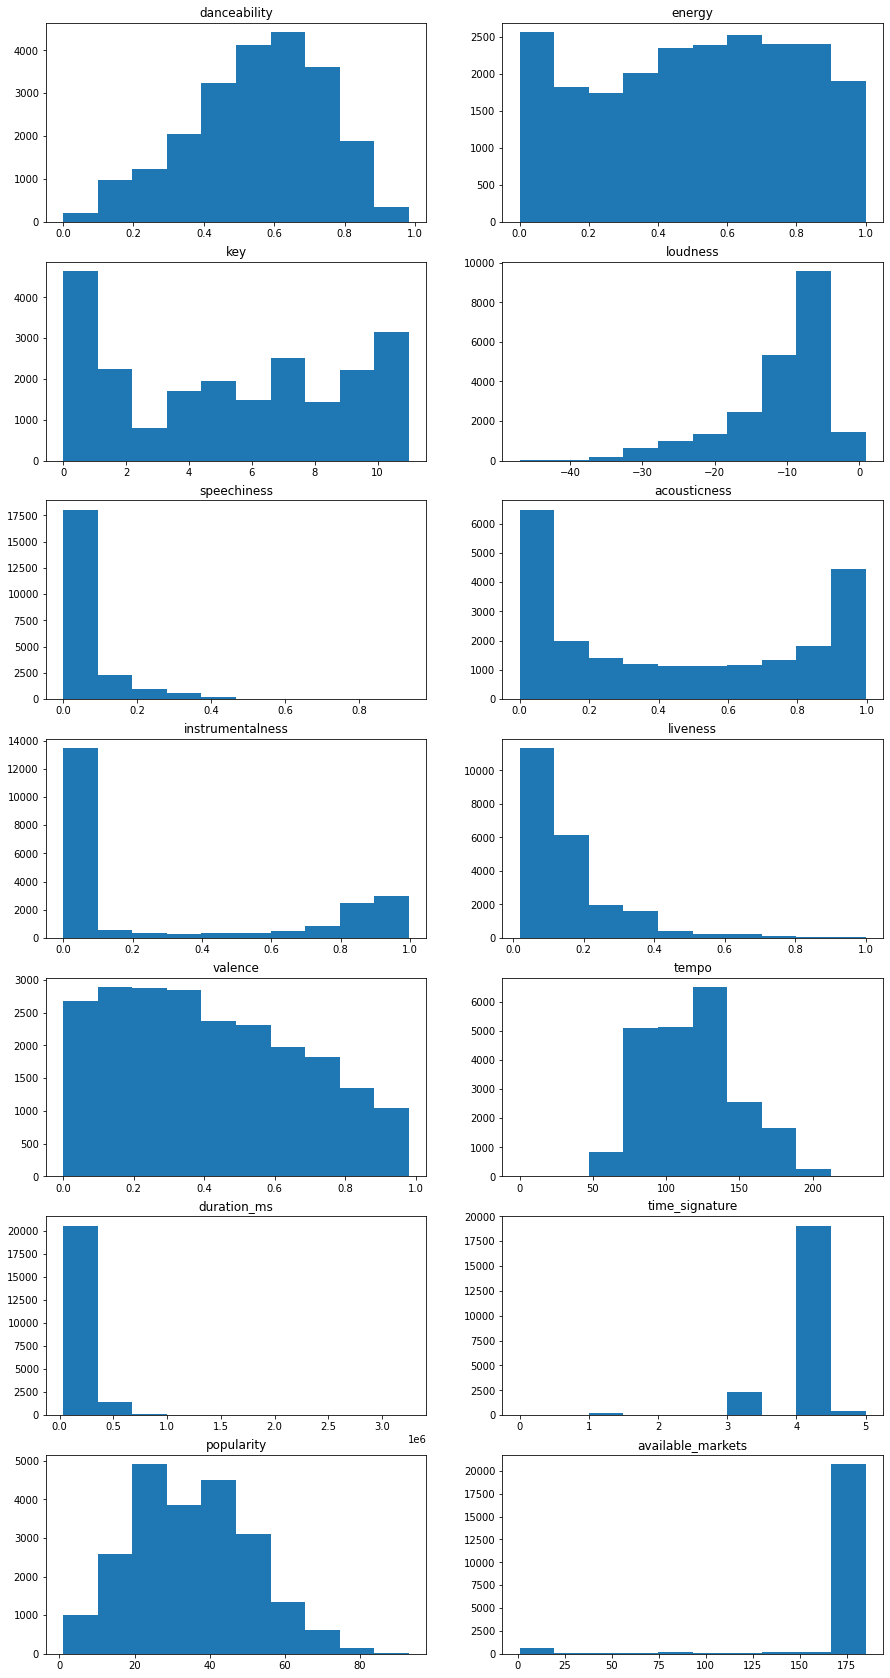

In [129]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14)) = plt.subplots(7, 2,figsize=(15,30))
ax1.hist(df[['danceability']])
ax2.hist(df[['energy']])
ax3.hist(df[['key']])
ax4.hist(df[['loudness']])
ax5.hist(df[['speechiness']])
ax6.hist(df[['acousticness']])
ax7.hist(df[['instrumentalness']])
ax8.hist(df[['liveness']])
ax9.hist(df[['valence']])
ax10.hist(df[['tempo']])
ax11.hist(df[['duration_ms']])
ax12.hist(df[['time_signature']])
ax13.hist(df[['popularity_track']])
ax14.hist(df[['available_markets']])

ax1.title.set_text('danceability')
ax2.title.set_text('energy')
ax3.title.set_text('key')
ax4.title.set_text('loudness')
ax5.title.set_text('speechiness')
ax6.title.set_text('acousticness')
ax7.title.set_text('instrumentalness')
ax8.title.set_text('liveness')
ax9.title.set_text('valence')
ax10.title.set_text('tempo')
ax11.title.set_text('duration_ms')
ax12.title.set_text('time_signature')
ax13.title.set_text('popularity')
ax14.title.set_text('available_markets')

Text(0, 0.5, 'frequency')

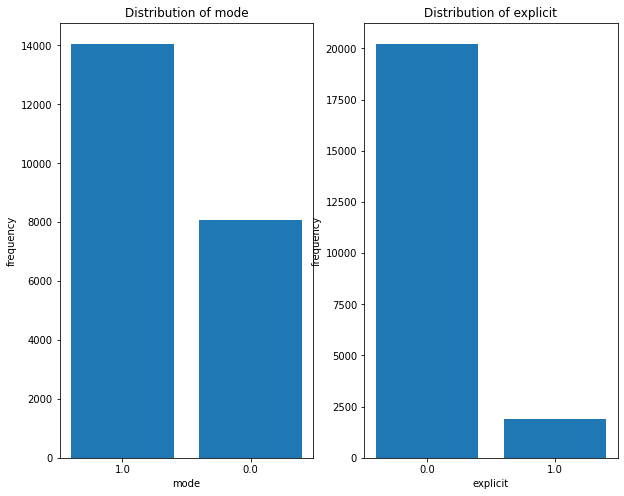

In [130]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
ax[0].bar(    
    x=list(map(str,df[catego_columns[0]].value_counts().keys().tolist())),
    height=df[catego_columns[0]].value_counts().values
    )
ax[0].set_title("Distribution of mode")
ax[0].set_xlabel("mode")
ax[0].set_ylabel("frequency")
ax[1].bar(    
    x=list(map(str,df[catego_columns[1]].value_counts().keys().tolist())),
    height=df[catego_columns[1]].value_counts().values
    )
ax[1].set_title("Distribution of explicit")
ax[1].set_xlabel("explicit")
ax[1].set_ylabel("frequency")

Text(0.5, 1.0, 'Popularity Based on Time Signature')

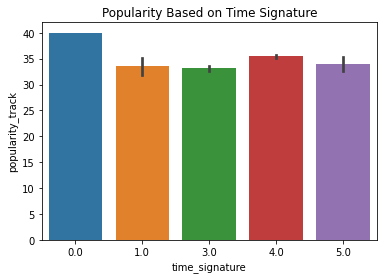

In [143]:
sns.barplot(x = 'time_signature', y = 'popularity_track', data = df)
plt.title('Popularity Based on Time Signature')

Text(0.5, 1.0, 'Popularity Based on Key')

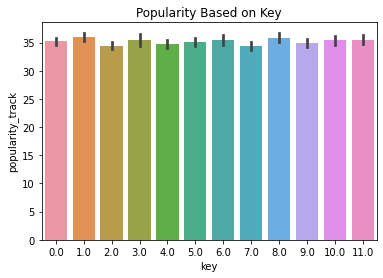

In [144]:
sns.barplot(x = 'key', y = 'popularity_track', data = df)
plt.title('Popularity Based on Key')

Text(0.5, 1.0, 'Popularity Based on Mode')

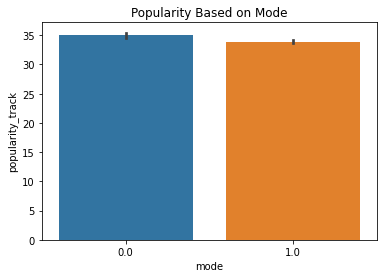

In [38]:
sns.barplot(x = 'mode', y = 'popularity_track', data = df)
plt.title('Popularity Based on Mode')

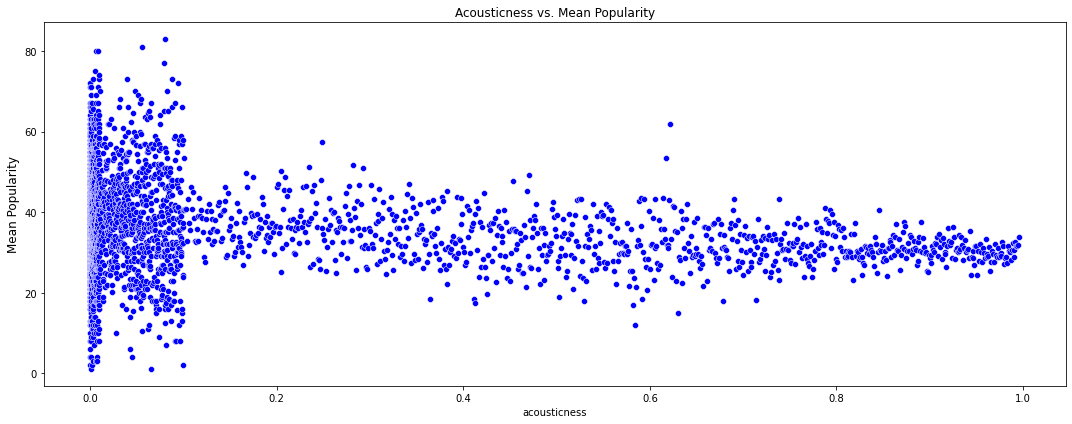

In [40]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('acousticness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['acousticness'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Acousticness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

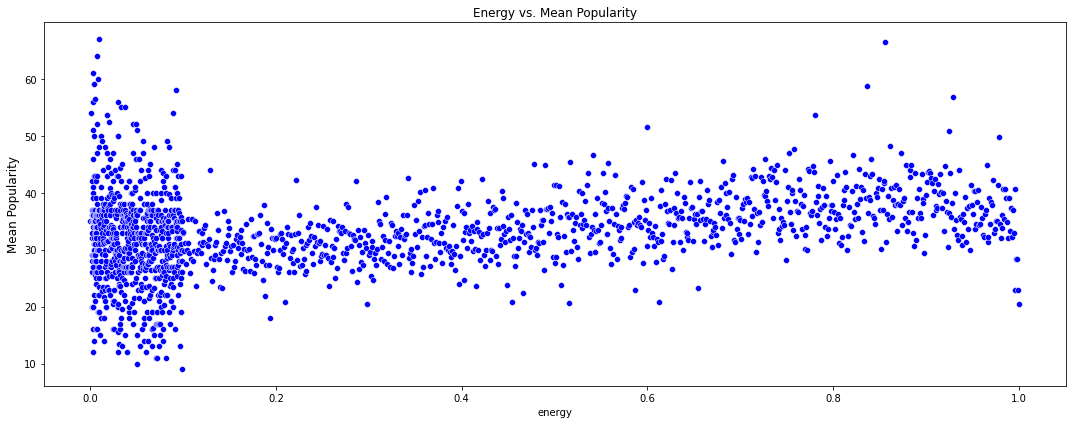

In [41]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('energy')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['energy'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Energy vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

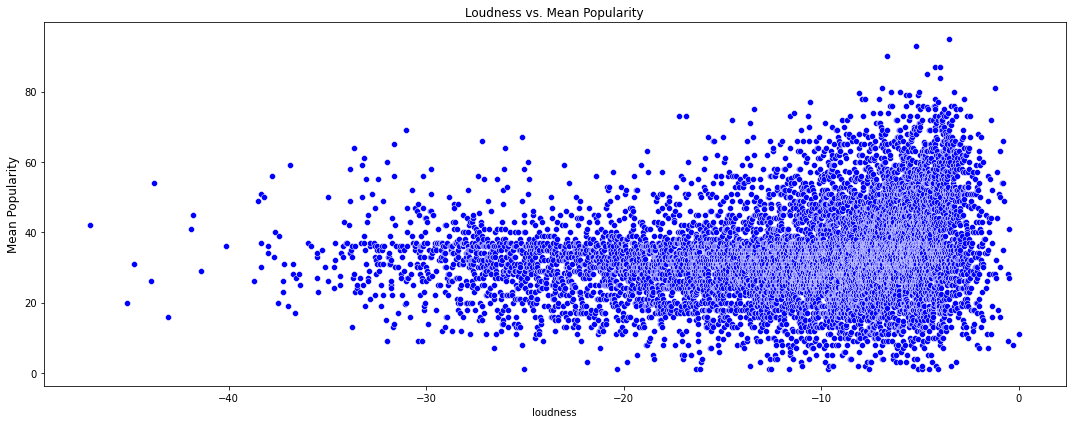

In [42]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('loudness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['loudness'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Loudness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

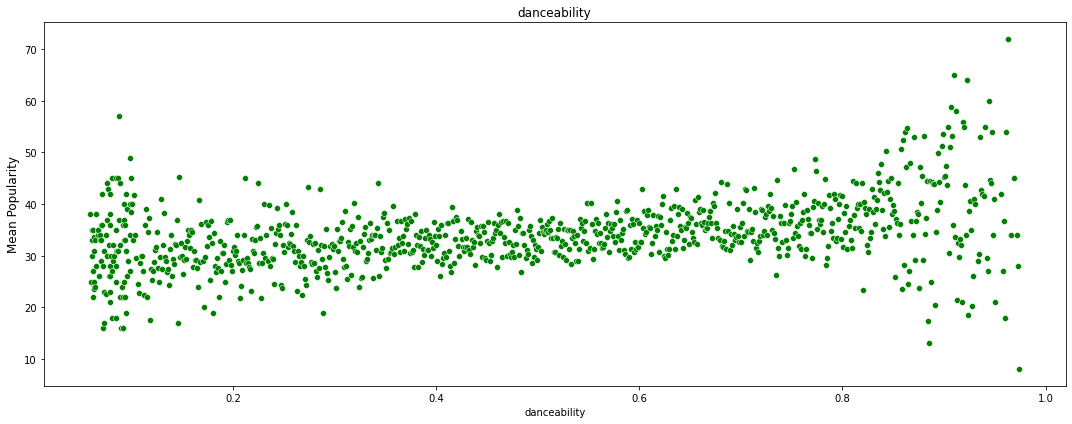

In [43]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('danceability')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='danceability', y='popularity_track', data=ax_data, color='green', ax=ax)
ax.set_title('danceability')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

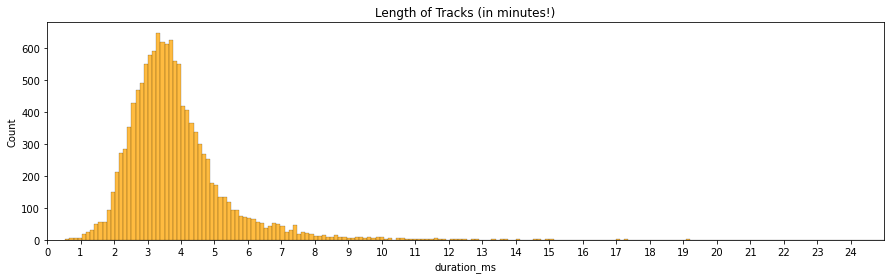

In [44]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.histplot(df['duration_ms']/60000, color='orange')
ax.set_title('Length of Tracks (in minutes!)')
ax.set_xticks(range(0,25,1))
ax.set_xlim(0,25)
plt.show()

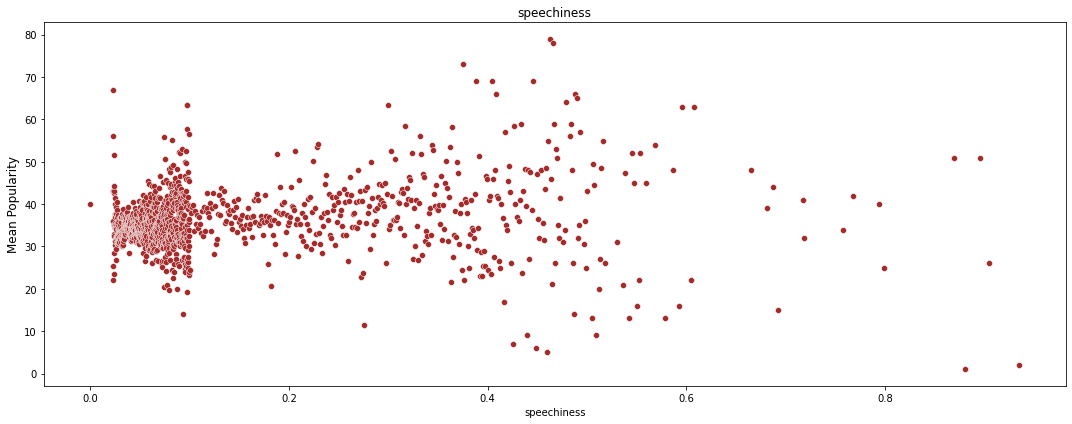

In [145]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('speechiness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='speechiness', y='popularity_track', data=ax_data, color='brown', ax=ax)
# ax.axvline(x=0.57, ymin=0, ymax=1, color='red', linestyle='dashed')
ax.set_title('speechiness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

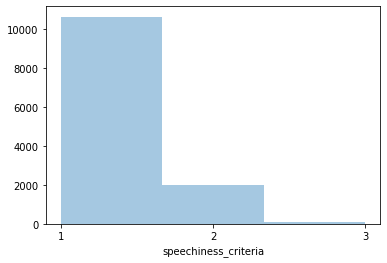

In [51]:
criteria= [df['speechiness'].between(0, 0.1),
           df['speechiness'].between(0.1000001, 0.40),
           df['speechiness'].between(0.400001, 1)]
values = [1, 2, 3]
df['speechiness_criteria'] = np.select(criteria, values, 0)
fig, ax = plt.subplots()
sns.distplot(df['speechiness_criteria'],ax=ax, kde=False, bins=3 )
ax.set_xticks(range(1,4))
plt.show()

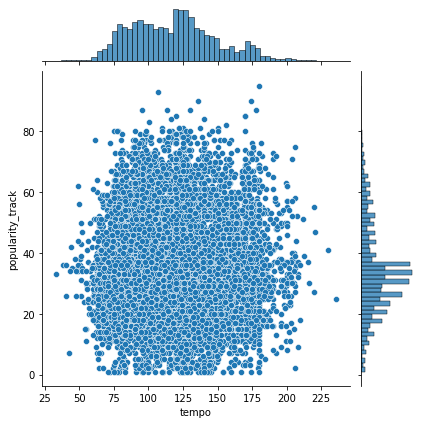

In [53]:
sns.jointplot(x='tempo', y='popularity_track', data=df)
plt.show()

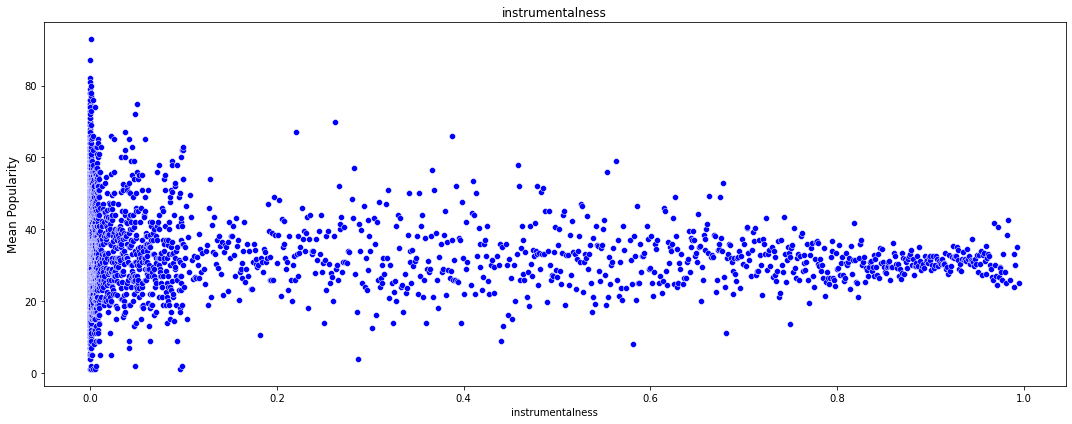

In [54]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('instrumentalness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='instrumentalness', y='popularity_track', data=ax_data, color='blue', ax=ax)
ax.set_title('instrumentalness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

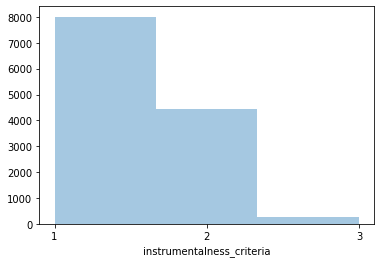

In [55]:
criteria= [df['instrumentalness'].between(0, 0.1),
           df['instrumentalness'].between(0.1000001, 0.95),
           df['instrumentalness'].between(0.950001, 1)]
values = [1, 2, 3]
df['instrumentalness_criteria'] = np.select(criteria, values, 0)
fig, ax = plt.subplots()
sns.distplot(df['instrumentalness_criteria'],ax=ax, kde=False, bins=3 )
ax.set_xticks(range(1,4))
plt.show()

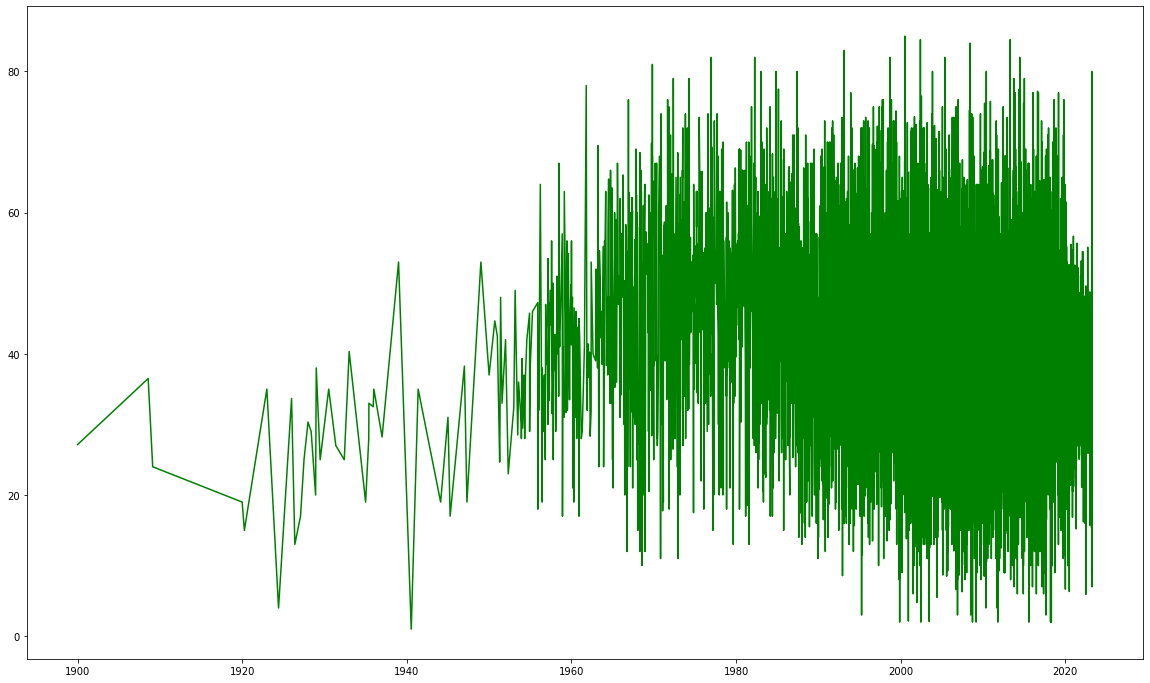

In [36]:
date_with_mean_pop = df.groupby('release_date')['popularity_track'].mean().to_frame().reset_index()
plt.figure(figsize=(20,12))
plt.plot_date(date_with_mean_pop[['release_date']],date_with_mean_pop[['popularity_track']], 'g')

## Correlation between features

<Axes: >

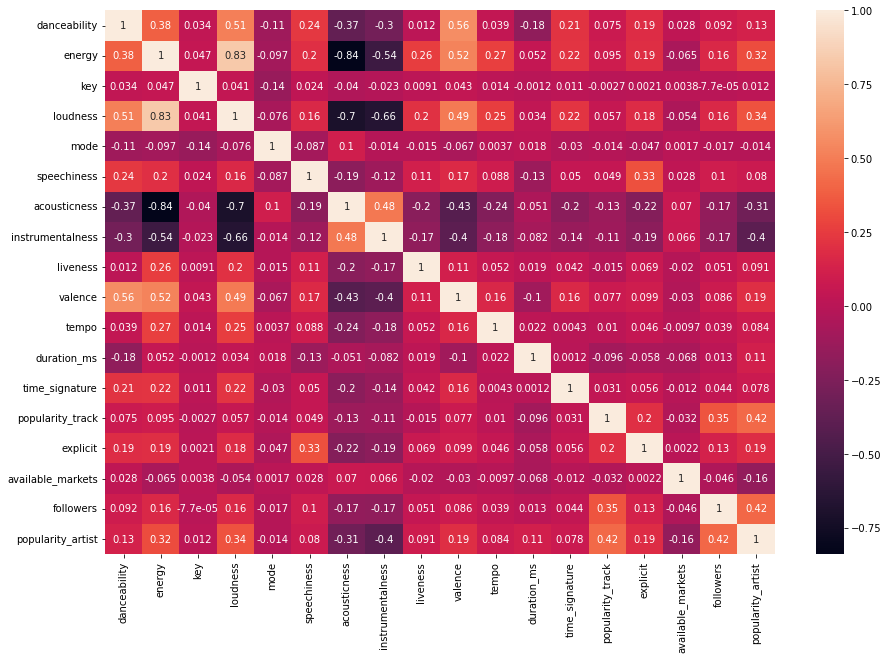

In [37]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

# Model Buiding

In [110]:
df.head()

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,name,popularity_track,explicit,available_markets,followers,popularity_artist
0,2023-03-24,0.445,0.232,1.0,-9.145,1.0,0.0294,0.886,0.000003,0.1280,0.246,72.005,204503.0,4.0,Face in the Crowd,36.0,0.0,134.0,341380.0,64.0
1,2023-03-24,0.615,0.552,3.0,-6.003,1.0,0.0397,0.312,0.000000,0.1300,0.319,119.014,222494.0,4.0,Can I Jump?,56.0,0.0,134.0,341380.0,64.0
2,2023-03-24,0.655,0.715,11.0,-2.837,1.0,0.0361,0.135,0.000000,0.0589,0.382,120.086,200480.0,4.0,Weekends,34.0,1.0,134.0,341380.0,64.0
3,2023-03-24,0.426,0.457,3.0,-8.235,1.0,0.0308,0.262,0.010900,0.0669,0.769,105.073,156857.0,3.0,midnight rendezvous,45.0,0.0,176.0,15891.0,45.0
4,2023-03-31,0.825,0.124,0.0,-11.175,0.0,0.0706,0.800,0.000003,0.2430,0.286,104.724,230333.0,3.0,What Makes Me Tick (Early Demo),6.0,0.0,179.0,73371.0,41.0


First, we need to split the data.

If we consider the usecase of Spotify, the company certainly wants to predict the popularity of future songs. Thus, we should split the dataset between songs issued before a certain year and songs issued after it.

We will make a train set of all the songs previous to 2022-9-30, and a test set composed of the songs issued on and after 2022-9-30 (20% of the total dataset).

In [116]:
X = df.sort_values(by='release_date').drop(columns=['popularity_track','name']).copy()
y = df.sort_values(by='release_date')['popularity_track'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [190]:
X_train.tail(5)

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,available_markets,followers,popularity_artist
46843,2022-09-30,0.799,0.0598,0.0,-21.153,1.0,0.1080,0.957,0.838000,0.1100,0.101,96.029,141968.0,4.0,0.0,185.0,0.0,0.0
46809,2022-09-30,0.602,0.2200,9.0,-14.672,0.0,0.0358,0.949,0.787000,0.1190,0.227,69.474,234060.0,4.0,0.0,185.0,0.0,0.0
18232,2022-09-30,0.429,0.2020,4.0,-13.995,0.0,0.0488,0.943,0.918000,0.0796,0.260,84.250,185000.0,4.0,0.0,184.0,14.0,23.0
46789,2022-09-30,0.705,0.4930,4.0,-7.120,1.0,0.0552,0.283,0.000688,0.1250,0.794,149.957,255765.0,4.0,0.0,185.0,0.0,0.0
26746,2022-09-30,0.586,0.1110,5.0,-13.610,0.0,0.0561,0.867,0.890000,0.0665,0.195,106.508,389789.0,4.0,0.0,184.0,515.0,33.0


In [117]:
X_train['release_date']=X_train['release_date'].map(dt.datetime.toordinal)
X_test['release_date']=X_test['release_date'].map(dt.datetime.toordinal)

In [185]:
X_train

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,available_markets,followers,popularity_artist
7372,693596,0.577,0.30300,0.0,-11.966,1.0,1,0.951,1,0.2150,0.825,134.642,218867.0,4.0,0.0,181.0,19385.0,40.0
7376,693596,0.550,0.29000,10.0,-14.191,0.0,1,0.881,1,0.1630,0.427,91.583,191467.0,4.0,0.0,181.0,19385.0,40.0
28684,693596,0.385,0.00189,1.0,-28.565,1.0,1,0.993,3,0.0955,0.153,93.131,597960.0,4.0,0.0,184.0,1494342.0,54.5
7373,693596,0.535,0.24900,0.0,-12.238,0.0,1,0.952,1,0.0905,0.823,93.297,194760.0,4.0,0.0,181.0,19385.0,40.0
7377,693596,0.394,0.31400,0.0,-11.151,0.0,1,0.847,1,0.1680,0.520,71.110,151133.0,4.0,0.0,181.0,19385.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46843,738428,0.799,0.05980,0.0,-21.153,1.0,2,0.957,3,0.1100,0.101,96.029,141968.0,4.0,0.0,185.0,0.0,0.0
46809,738428,0.602,0.22000,9.0,-14.672,0.0,1,0.949,3,0.1190,0.227,69.474,234060.0,4.0,0.0,185.0,0.0,0.0
18232,738428,0.429,0.20200,4.0,-13.995,0.0,1,0.943,3,0.0796,0.260,84.250,185000.0,4.0,0.0,184.0,14.0,23.0
46789,738428,0.705,0.49300,4.0,-7.120,1.0,1,0.283,1,0.1250,0.794,149.957,255765.0,4.0,0.0,185.0,0.0,0.0


In [191]:
y_train.tail(5)

46843    42.0
46809    49.0
18232    27.0
46789    58.0
26746    42.0
Name: popularity_track, dtype: float64

In [115]:
X_train.columns

Index(['release_date', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'explicit',
       'available_markets', 'followers', 'popularity_artist'],
      dtype='object')

In [118]:
def instrumentalness_criteria(X):
    X.loc[:,'instrumentalness'] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.4 else 2)), X.loc[:,'instrumentalness']))

instrumentalness_tranformer = FunctionTransformer(instrumentalness_criteria)
instrumentalness_tranformer.transform(X_train)
instrumentalness_tranformer.transform(X_test)

In [119]:
def speechiness_criteria(X):
    X.loc[:,'speechiness'] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.95 else 2)), X.loc[:,'speechiness']))

speechiness_tranformer = FunctionTransformer(speechiness_criteria)
speechiness_tranformer.transform(X_train)
speechiness_tranformer.transform(X_test)

In [120]:
ct = ColumnTransformer([('minmax', MinMaxScaler(), ['release_date','loudness', 'tempo', 'duration_ms','available_markets','followers','popularity_artist']),
                        ('categorical', OneHotEncoder(handle_unknown = 'ignore'), ['key','mode','time_signature','explicit','instrumentalness','speechiness']),
                       ],
                       remainder='passthrough')

ct.fit(X_train)
joblib.dump(ct, 'Popularity Prediction Data Preprocess.sav')

X_train_preprocessed = pd.DataFrame(ct.transform(X_train).tolist())
X_test_preprocessed = pd.DataFrame(ct.transform(X_test).tolist())

In [119]:
X_test_preprocessed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,1.000000,0.685767,0.534315,0.043120,1.000000,0.000064,0.260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.610,0.2050,0.9070,0.1100,0.2520
1,1.000000,0.721501,0.411168,0.085009,0.994565,0.000005,0.360,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.565,0.2720,0.8880,0.1020,0.2470
2,1.000000,0.792623,0.547765,0.087685,1.000000,0.000054,0.365,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.785,0.8880,0.0106,0.0431,0.0695
3,1.000000,0.823338,0.748192,0.026395,1.000000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.738,0.3160,0.6640,0.1270,0.5950
4,1.000000,0.498503,0.763272,0.044994,1.000000,0.000000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.272,0.0356,0.9940,0.0975,0.0986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14942,1.004149,0.802031,0.774424,0.037004,0.994565,0.003286,0.540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.672,0.6800,0.0286,0.0929,0.8650
14943,1.004149,0.799421,0.411938,0.034435,0.994565,0.003286,0.540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.722,0.6130,0.1190,0.1120,0.3980
14944,1.004149,0.797034,0.623842,0.054002,0.994565,0.003286,0.540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.454,0.6810,0.0777,0.1300,0.3340
14945,1.004171,0.703290,0.587576,0.071812,0.994565,0.004742,0.780,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.447,0.1600,0.8800,0.1110,0.2290


In [121]:
# y_train = y_train / 100
# y_test = y_test/100
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [122]:
# verifictaion
nl = '\n'
print(f'X_train_preprocessed shape is: {X_train_preprocessed.shape} {nl}y_train shape is: {y_train.shape} {nl}X_test_preprocessed shape is: {X_test_preprocessed.shape} {nl}y_test shape is: {y_test.shape}')

X_train_preprocessed shape is: (50269, 39) 
y_train shape is: (50269,) 
X_test_preprocessed shape is: (12568, 39) 
y_test shape is: (12568,)


### Linear Regression (selected features only (corr > 0.1))

In [49]:
X_train_preprocessed.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,0.0,0.727146,0.599645,0.048146,0.978261,0.000175,0.400,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.577,0.30300,0.951,0.2150,0.825
1,0.0,0.682125,0.407877,0.041546,0.978261,0.000175,0.400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.550,0.29000,0.881,0.1630,0.427
2,0.0,0.391283,0.414771,0.139467,0.994565,0.013498,0.545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.385,0.00189,0.993,0.0955,0.153


In [50]:
X_train_preprocessed.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
count,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.000000,59788.00000,59788.000000
mean,0.919754,0.744456,0.522533,0.051069,0.950796,0.018876,0.449257,0.121295,0.087810,0.105924,0.038620,0.077758,0.091339,0.064495,0.110674,0.064980,0.097210,0.066836,0.073058,0.344601,0.655399,0.000100,0.010788,0.110423,0.861979,0.016709,0.930806,0.069194,0.650164,0.048271,0.301566,0.851442,0.148542,0.000017,0.544747,0.498429,0.466198,0.16651,0.418104
std,0.112405,0.156371,0.137100,0.023192,0.181905,0.064032,0.248189,0.326473,0.283021,0.307743,0.192689,0.267793,0.288094,0.245634,0.313731,0.246492,0.296246,0.249740,0.260234,0.475242,0.475242,0.010017,0.103305,0.313420,0.344925,0.128180,0.253787,0.253787,0.476922,0.214339,0.458941,0.355655,0.355639,0.004090,0.187424,0.292085,0.372559,0.13291,0.257469
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000270,0.000000,0.00724,0.000000
25%,0.888026,0.687285,0.414263,0.038788,0.994565,0.000022,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.423000,0.251000,0.078600,0.09640,0.200000
50%,0.971404,0.797317,0.521493,0.047768,0.994565,0.001054,0.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.561000,0.516000,0.431000,0.11400,0.385000
75%,0.991569,0.853891,0.610054,0.058339,1.000000,0.008797,0.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.686000,0.746000,0.858000,0.18300,0.618000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984000,1.000000,0.996000,1.00000,0.987000


In [78]:
LR = LinearRegression()
cols = [col for col in X_train_preprocessed.columns if abs(X_train_preprocessed[col].corr(y_train))>0.1]

# Fit the model and
LR.fit(X_train_preprocessed.drop(columns=cols), y_train)

# Train Predicting with the model
y_train_pred = LR.predict(X_train_preprocessed.drop(columns=cols))#.clip(0, 1)

# RMSE Train
LR_rmse = np.sqrt(mse(y_train, y_train_pred))
print(f"RMSE Train = {LR_rmse:.5f}")

RMSE Train = 16.50997


In [79]:
#Predicting with the model
y_test_pred = LR.predict(X_test_preprocessed.drop(columns=cols))#.clip(0, 1)

# RMSE Test
LR_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Val = {LR_rmse:.5f}")

RMSE Val = 16.37736


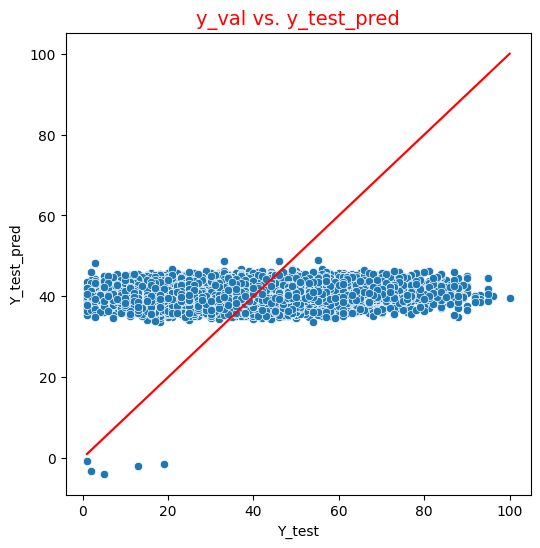

In [80]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_val vs. y_test_pred', fontsize=14, color='red')
plt.show()

### Linear Regression (all features)

In [82]:
# Count time
start_time = timeit.default_timer()
LR = LinearRegression()

# Fit the model and
LR.fit(X_train_preprocessed, y_train)
elapsed_1 = timeit.default_timer() - start_time

# Train Predicting with the model
y_train_pred2 = LR.predict(X_train_preprocessed)#.clip(0, 1)

# RMSE Train
LR_rmse2 = np.sqrt(mse(y_train, y_train_pred2))
print(f"RMSE Train = {LR_rmse2:.6f}")

RMSE Train = 11.654110


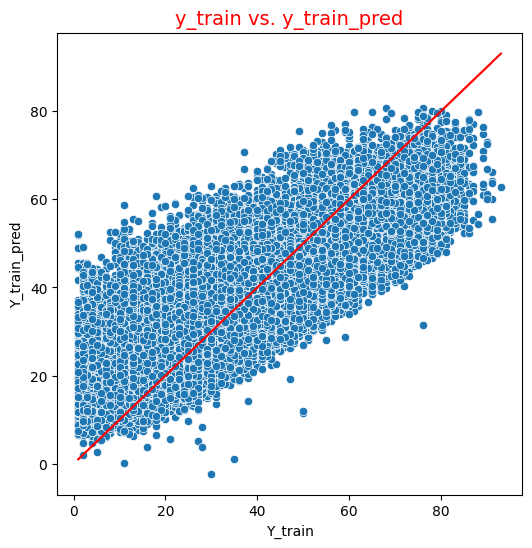

In [83]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_train, y=y_train_pred2)
sns.lineplot(x=y_train, y=y_train, color='red', ax=ax)
ax.set_xlabel('Y_train')
ax.set_ylabel('Y_train_pred')
ax.set_title('y_train vs. y_train_pred', fontsize=14, color='red')
plt.show()

In [84]:
#Predicting with the model
start_time = timeit.default_timer()
y_test_pred = LR.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_1_predict = timeit.default_timer() - start_time

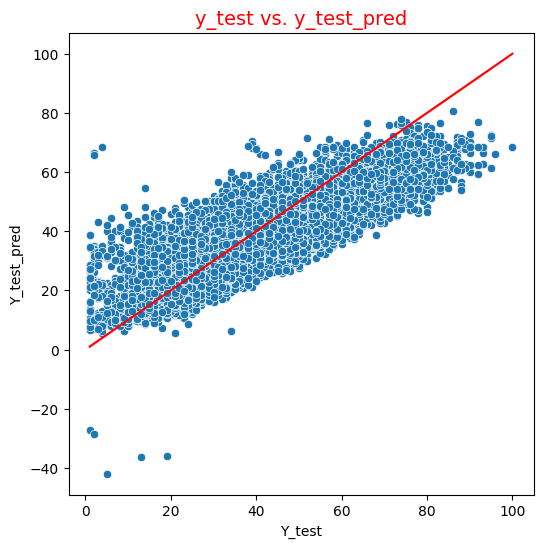

In [85]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [86]:
model = sm.OLS(list(y_train), X_train_preprocessed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     1591.
Date:                Sat, 08 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:09:28   Log-Likelihood:            -1.9477e+05
No. Observations:               50269   AIC:                         3.896e+05
Df Residuals:                   50235   BIC:                         3.899e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.0203      0.481      2.120      0.034       0.077       1.964
1             -5.0052      0.765     -6.544      0.000      -6.504      -3.506
2              0.6538      0.404      1.617      0.106      -0.139       1.446
3            -57.6562      2.297    -25.106      0.000     -62.157     -53.155
4              2.2603      0.269      8.394      0.000       1.732       2.788
5              9.8998      0.871     11.367      0.000       8.193      11.607
6             60.6286      0.338    179.342      0.000      59.966      61.291
7             -0.1783      0.228     -0.781      0.435      -0.626       0.269
8              0.0013      0.243      0.005      0.996      -0.475       0.478
9             -0.0349      0.234     -0.150      0.881      -0.493       0.423
10             0.3858      0.310      1.245      0.213      -0.221       0.993
11             0.2264      0.250      0.906      0.365      -0.263       0.716
12            -0.5951      0.242     -2.458      0.014      -1.070      -0.121
13             0.1832      0.262      0.700      0.484      -0.330       0.696
14            -0.3370      0.232     -1.455      0.146      -0.791       0.117
15             0.0315      0.260      0.121      0.903      -0.478       0.541
16             0.1599      0.237      0.674      0.500      -0.305       0.625
17            -0.4734      0.260     -1.824      0.068      -0.982       0.035
18             0.0166      0.254      0.065      0.948      -0.482       0.515
19            -0.2721      1.046     -0.260      0.795      -2.322       1.778
20            -0.3420      1.046     -0.327      0.744      -2.393       1.709
21             6.7963      3.931      1.729      0.084      -0.909      14.502
22            -1.7157      1.048     -1.637      0.102      -3.770       0.338
23            -2.2579      0.966     -2.337      0.019      -4.152      -0.364
24            -1.7707      0.961     -1.843      0.065      -3.654       0.112
25            -1.6660      1.015     -1.641      0.101      -3.656       0.324
26            -2.4744      1.047     -2.363      0.018      -4.527      -0.422
27             1.8603      1.053      1.766      0.077      -0.204       3.925
28            -0.5494      0.707     -0.777      0.437      -1.935       0.836
29            -0.1740      0.717     -0.243      0.808      -1.579       1.231
30             0.1093      0.703      0.156      0.876      -1.268       1.487
31            18.4088      3.230      5.700      0.000      12.078      24.739
32            16.8630      3.231      5.219      0.000      10.530      23.196
33           -35.8859      8.442     -4.251      0.000     -52.432     -19.340
34             1.6359      0.401      4.076      0.000       0.849       2.423
35            -1.8060      0.456     -3.960      0.000      -2.700      -0.912
36

In [87]:
r2_lr = r2_score(y_test, y_test_pred)
LR_rmse2 = np.sqrt(mse(y_test, y_test_pred))
print("R-Squared = {:.6f}".format(round(r2_lr, 6)))
print('Run time = ', elapsed_1)
print(f"RMSE Test = {LR_rmse2:.6f}")

R-Squared = 0.632764
Run time =  0.11523102999990442
RMSE Test = 9.974760


### Lasso

In [89]:
# Count time
start_time = timeit.default_timer()
# Lasso
lasso=Lasso()
lasso_fit = lasso.fit(X_train_preprocessed,y_train)
elapsed_2 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
y_pred = lasso.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_2_predict = timeit.default_timer() - start_time
mean_squared_error(y_test, y_pred, squared=False)

11.831564378781858

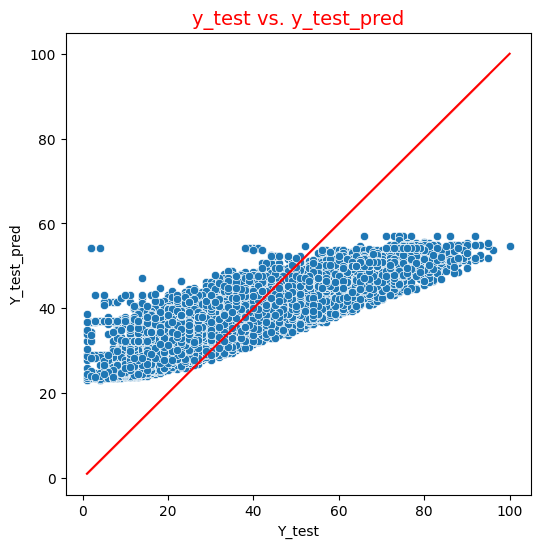

In [90]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [91]:
r2_lasso = r2_score(y_test, y_pred)
lasso_rmse = np.sqrt(mse(y_test, y_pred))
print('Run time = ', elapsed_2)
print(f"RMSE Test = {lasso_rmse:.6f}")

Run time =  0.02816926000014064
RMSE Test = 11.831564


### XGBoost Regression

In [92]:
# Count time
start_time = timeit.default_timer()
# XGBoost regressor
xgb_regressor = XGBRegressor(n_estimators=100, max_depth=20, learning_rate=0.01)
xgb_fit = xgb_regressor.fit(X_train_preprocessed, y_train)
elapsed_3 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
y_pred_xg = xgb_regressor.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_3_predict = timeit.default_timer() - start_time
mean_squared_error(y_test, y_pred_xg, squared=False)

20.308771630213524

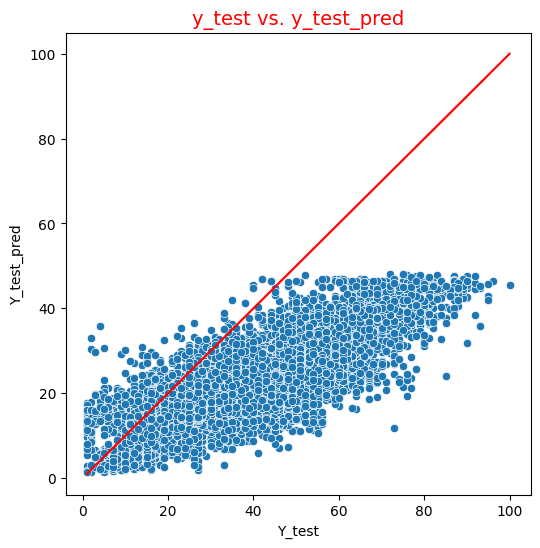

In [93]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred_xg)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [94]:
xgboost_rmse = np.sqrt(mse(y_test, y_pred_xg))
print('Run time = ', elapsed_3)
print(f"RMSE Test = {xgboost_rmse:.6f}")

Run time =  20.708872737000092
RMSE Test = 20.308772


### K-Nearest-Neighbors (KNN) Regression

In [95]:
# Count time
start_time = timeit.default_timer()
# K-Nearest-Neighbors (KNN) regressor
neigh = KNeighborsRegressor(n_neighbors=7)

neigh_fit = neigh.fit(X_train_preprocessed, y_train)
elapsed_4 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
y_pred_kn=neigh.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_4_predict = timeit.default_timer() - start_time

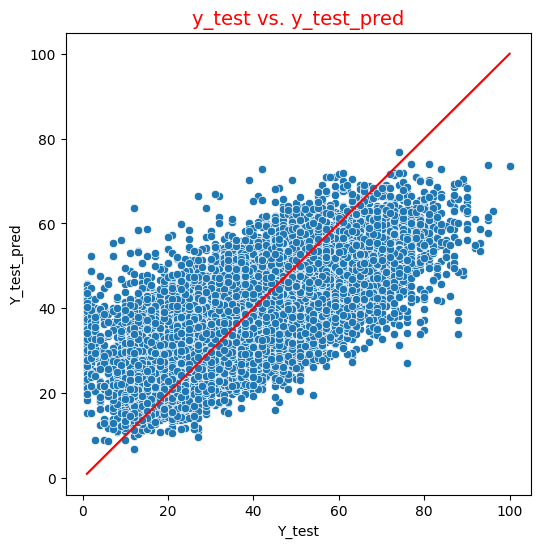

In [96]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred_kn)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [97]:
knn_rmse = np.sqrt(mse(y_test, y_pred_kn))
print(f"RMSE Test = {knn_rmse:.6f}")
print('Run time = ', elapsed_4)

RMSE Test = 12.438452
Run time =  0.021403783000096155


### Polynomial

In [98]:
# Count time
start_time = timeit.default_timer()
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_train_preprocessed)
pol_reg = LinearRegression()
model_log = sm.OLS(y_train, X_poly).fit()
elapsed_5 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
X_poly_test = poly.transform(X_test_preprocessed)
y_test_pred = model_log.predict(X_poly_test)#.clip(0, 1)
elapsed_5_predict = timeit.default_timer() - start_time

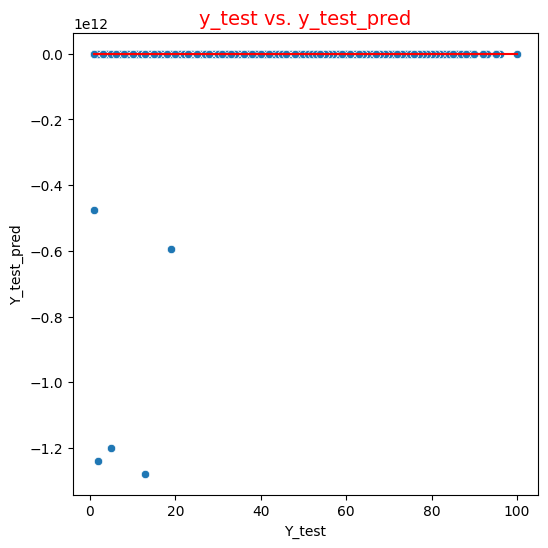

In [99]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [100]:
poly_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Test = {poly_rmse:.6f}")
print('Run Time = ', elapsed_5)

RMSE Test = 20312467031.312595
Run Time =  7.737265006999905


## Model Comparison

Comparing Linear, Lasso, Polinomial, XGboost, KNN, the RMSE of XGboost is the highest. We may use XGboost regression for the final model.

In [101]:
rmse = [LR_rmse2,lasso_rmse,xgboost_rmse,knn_rmse,poly_rmse]
time = [elapsed_1, elapsed_2,elapsed_3,elapsed_4,elapsed_5]
time_predict = [elapsed_1_predict, elapsed_2_predict,elapsed_3_predict,elapsed_4_predict,elapsed_5_predict]
name = ['Linear Regression','Lasso Regression','XGboost Regression','K-Nearest-Neighbors Regression','Polynomial Regresson']
r2_df = pd.DataFrame([name,rmse,time,time_predict]).T
r2_df.columns = ['Method','RMSE Score','Fitting Time(s)','Predicting Time(s)']
r2_df

,Method,RMSE Score,Fitting Time(s),Predicting Time(s)
0,Linear Regression,9.97476,0.115231,0.003352
1,Lasso Regression,11.831564,0.028169,0.002905
2,XGboost Regression,20.308772,20.708873,0.05833
3,K-Nearest-Neighbors Regression,12.438452,0.021404,1.142314
4,Polynomial Regresson,20312467031.312595,7.737265,0.118622


In [183]:
# export model
#joblib.dump(poly, 'Popularity Prediction Poly Transform.sav')

['Popularity Prediction Poly Transform.sav']

In [123]:
# export model
joblib.dump(LR, 'Popularity Prediction Model.sav')

['Popularity Prediction Model.sav']